## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data cleaning
*By Lilly Sorkin*

In [ ]:
import pandas as pd
import numpy as np

stats = pd.read_csv('CollegeBasketballPlayers2009-2021.csv')
draft = pd.read_csv('DraftedPlayers2009-2021.csv')

# drop variables with more than 10,000 missing values
stats_2 = stats.drop(columns = ['pick','dunksmade/(dunksmade+dunksmiss)','midmade/(midmade+midmiss)','rimmade/(rimmade+rimmiss)', 'Rec Rank'])

# drop remaining instances with missing values
stats_no_missing = stats_2.dropna()

# adding the response variable to the dataset
all_players = list(stats_no_missing.player_name)
drafted_players =  list(draft.PLAYER)

for name in all_players:
    if name in drafted_players:
        stats_no_missing.loc[stats_no_missing.player_name == name, 'drafted'] = 1
    else:
        stats_no_missing.loc[stats_no_missing.player_name == name, 'drafted']  = 0

### Distribution of response
*By Lilly Sorkin*

In [ ]:
stats_no_missing.drafted.value_counts()

0.0    50059
1.0     1317
Name: drafted, dtype: int64

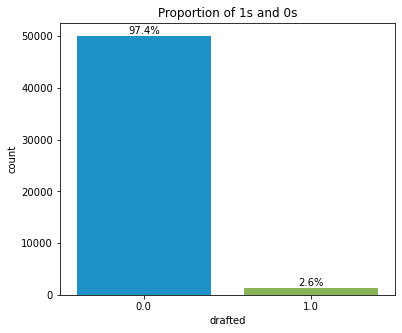

In [ ]:
# Distibution of 1s and 0s
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.title("Proportion of 1s and 0s")
ax = sns.countplot(data=stats_no_missing, x='drafted', palette=['#039be5','#8bc34a'])
for c in ax.containers:
    
    labels = [f'{h/stats_no_missing.drafted.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

### Data preparation
*By Lilly Sorkin*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Removing duplicate player names, keeping only the most recent instance

In [ ]:
# sorting by year
year_sorted = stats_no_missing.sort_values(by='year')
# keep only most recent instance with duplicate name entries
stats_unique = year_sorted.drop_duplicates(subset='player_name', keep='last')

## Exploratory data analysis
*By Isabel Knight & Lilly Sorkin*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

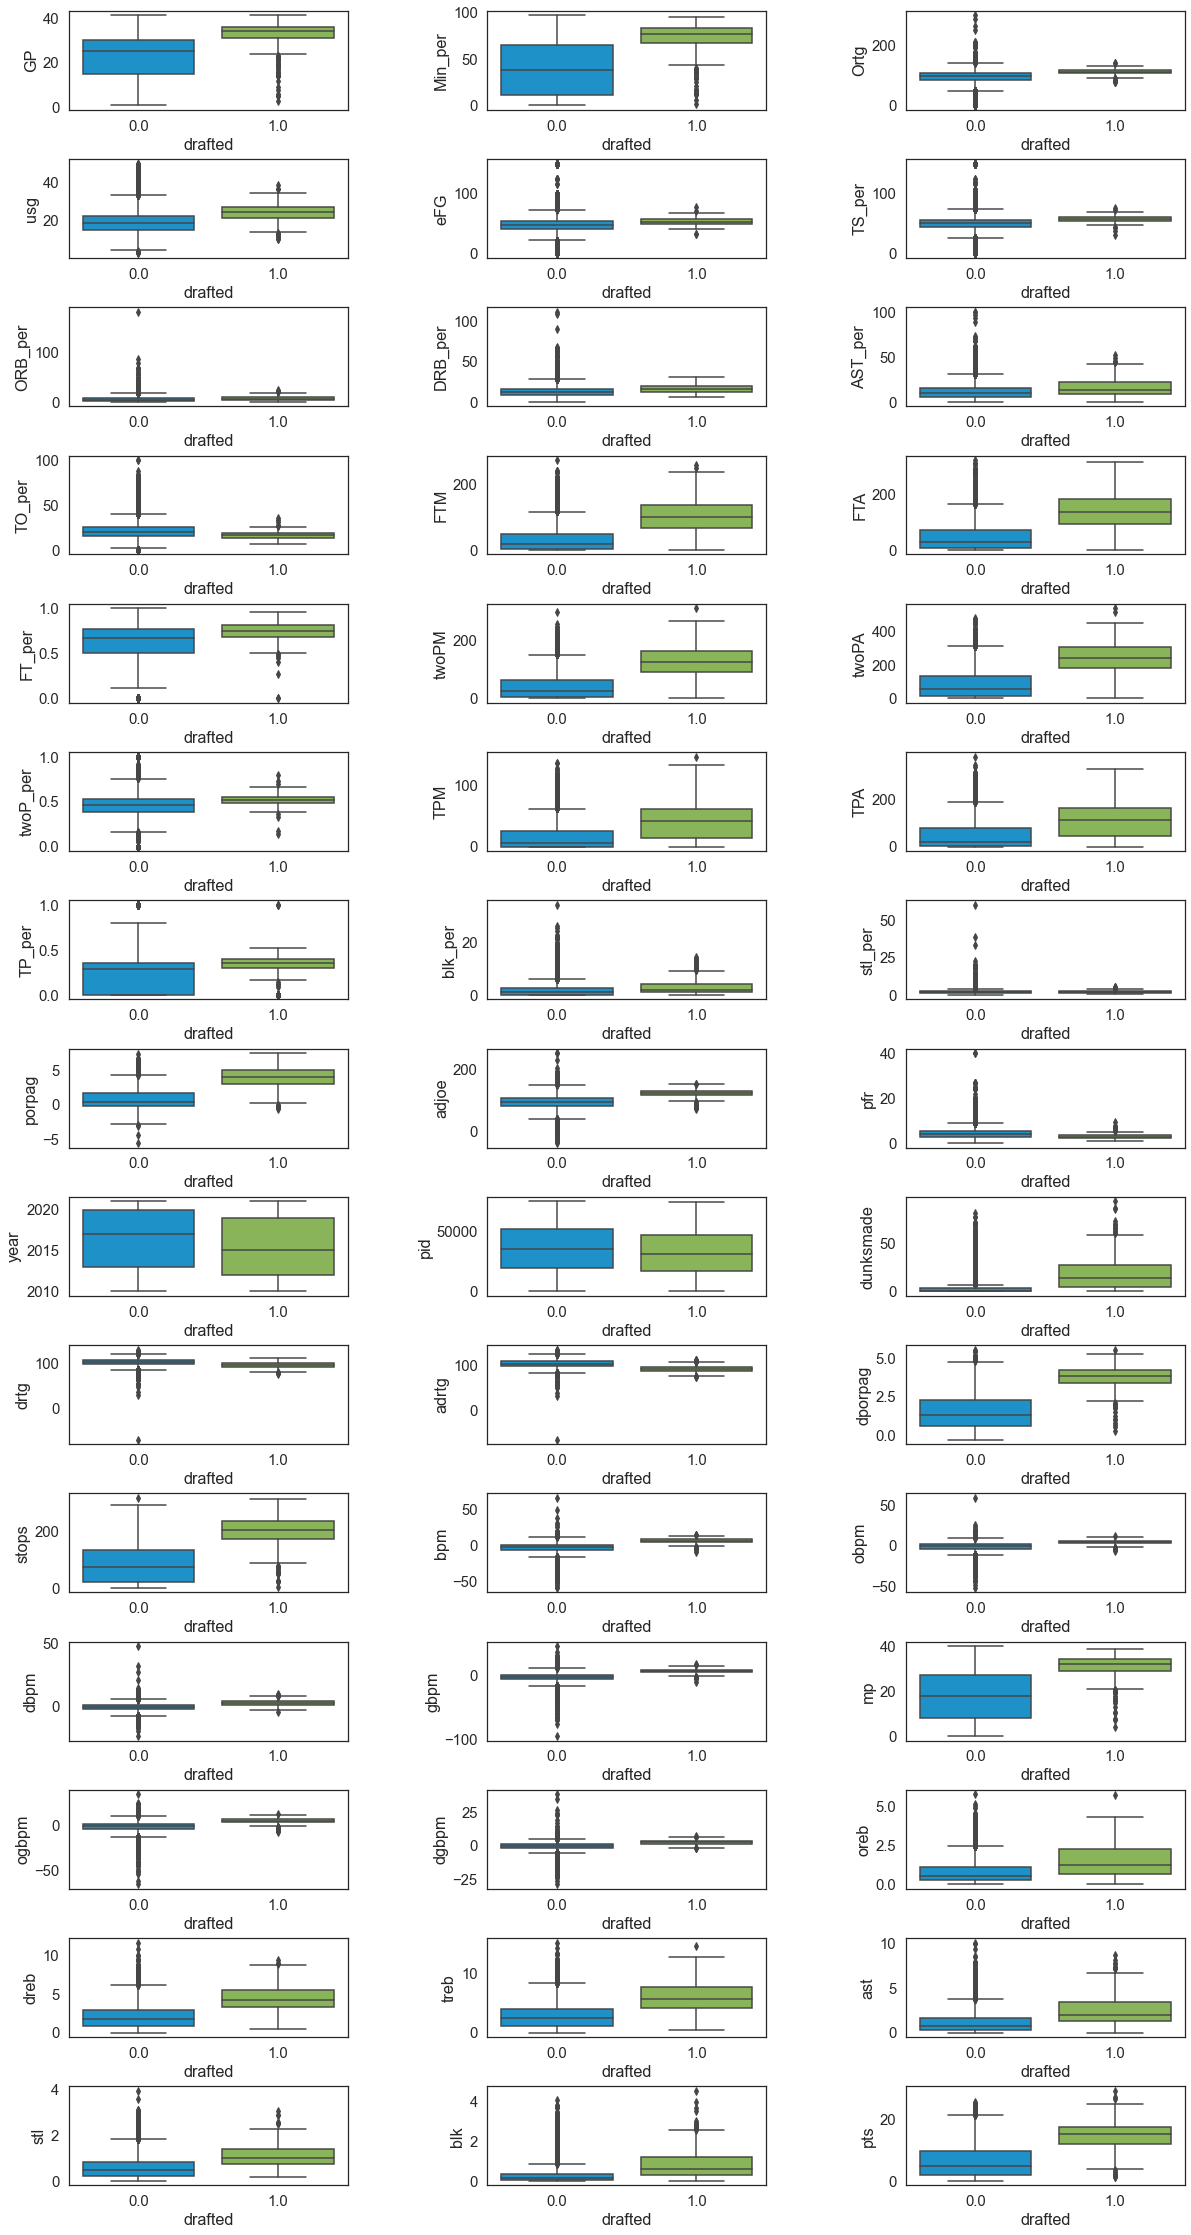

In [ ]:
# Isabel Knight
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set(font_scale=1.35)
sns.set_style("white")

data = stats_unique
y = data.drafted
X = data.drop("drafted", axis = 1)

# Creating training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45, stratify = y)
#remaking the dataframe as one for now
training = pd.concat([X_train, y_train], axis=1)
predictors = list(training.columns)
#removing cols we don't need
    #did this by hand by looking at df
predictors.remove("player_name")    
predictors.remove("rimmade+rimmiss")
predictors.remove('midmade+midmiss')
predictors.remove('dunksmiss+dunksmade')
predictors.remove('Unnamed: 64')
predictors.remove('Unnamed: 65')
predictors.remove('drafted')
predictors.remove('ast/tov')
predictors.remove('team')
predictors.remove('num')
predictors.remove('rimmade')
predictors.remove('midmade')
predictors.remove('dunksmade')
predictors.remove('type')

#dropping cols in training
training = training.drop(columns = ["player_name", "rimmade+rimmiss", 'midmade+midmiss','dunksmiss+dunksmade',
                                    'Unnamed: 64', 'Unnamed: 65', 'drafted', 'ast/tov', 'team', 'num', 'rimmade',
                                    'midmade','type'])

#eda of numeric vars
lst_num = list(training.columns)
lst_num.remove('conf')
lst_num.remove('ftr')
lst_num.remove('ht')
lst_num.remove('yr')


train = pd.concat([training, y_train], axis=1)

# Lilly Sorkin
fig, axes = plt.subplots(15, 3,figsize=(20,40))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
lst_array = np.reshape(lst_num, (15, 3))

for i in range(15):
    for j in range(3):
        sns.boxplot(ax=axes[i,j], data=train, x='drafted', y=lst_array[i,j], palette=['#039be5','#8bc34a'])

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### RandomForest & AdaBoost
*By Lilly Sorkin*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

data = stats_unique
cols = list(data.columns)
categorical_cols = []
numerical_cols = []
for item in cols:
    if data[item].dtype == object:
        categorical_cols.append(item)
    else:
        numerical_cols.append(item)
data = data.set_index('player_name')
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type', 'pid'], axis=1)
data_dummies = pd.get_dummies(data)
y = data_dummies.drafted
X = data_dummies.drop('drafted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45, stratify=y)

In [ ]:
# RandomForest hyperparameter selection
params = {'bootstrap': [True, False],
          'n_estimators': [10, 300, 500, 1000],
          'max_depth': [20, 25, 30, 35],
          'max_leaf_nodes': [100, 500, 1000]}

model_group = GridSearchCV(RandomForestClassifier(random_state=45, n_jobs=-1),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
0.3292110292110292 {'bootstrap': False, 'max_depth': 20, 'max_leaf_nodes': 500, 'n_estimators': 500}


<Figure size 800x800 with 0 Axes>

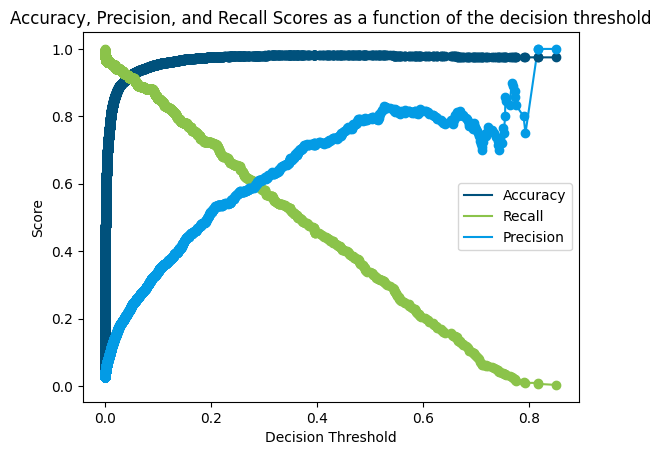

In [ ]:
# RandomForest final model
model1 = RandomForestClassifier(random_state=45, bootstrap=False,
                               n_estimators=500, max_leaf_nodes=500,
                               max_depth=20, n_jobs=-1)
model1.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model1, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [ ]:
# RandomForest decision threshold and results
desired_threshold = 0.05

ypred_prob_train = model1.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model1.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  1.0
Train Recall:  1.0
Test Accuracy:  0.9232431203093018
Test Recall:  0.9363636363636364


In [ ]:
feature_names = model1.feature_names_in_
predictors = []
for item in feature_names:
    predictors.append(item) 

feature_importances = np.mean([tree.feature_importances_ for tree in model1], axis=0)
importances = []
for item in feature_importances:
    importances.append(item) 
    
df_rf_importances = pd.DataFrame()
df_rf_importances['Predictor'] = predictors
df_rf_importances['Importance'] = importances
df_rf_importances.sort_values(by='Importance', ascending=False).head(10)

,Predictor,Importance
32,dporpag,0.049807
37,gbpm,0.043862
33,stops,0.036997
22,porpag,0.036491
34,bpm,0.034988
39,ogbpm,0.028670
23,adjoe,0.026751
31,adrtg,0.025221
450,yr_Sr,0.023887
35,obpm,0.023792


In [ ]:
# AdaBoost hyperparameter selection
params = {'base_estimator': [DecisionTreeClassifier(max_depth=7),
                             DecisionTreeClassifier(max_depth=8),
                             DecisionTreeClassifier(max_depth=9)],
          'n_estimators': [5, 10, 15],
          'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05]}

model_group = GridSearchCV(AdaBoostClassifier(random_state=45),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
0.5526344526344527 {'base_estimator': DecisionTreeClassifier(max_depth=8), 'learning_rate': 0.02, 'n_estimators': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

<Figure size 800x800 with 0 Axes>

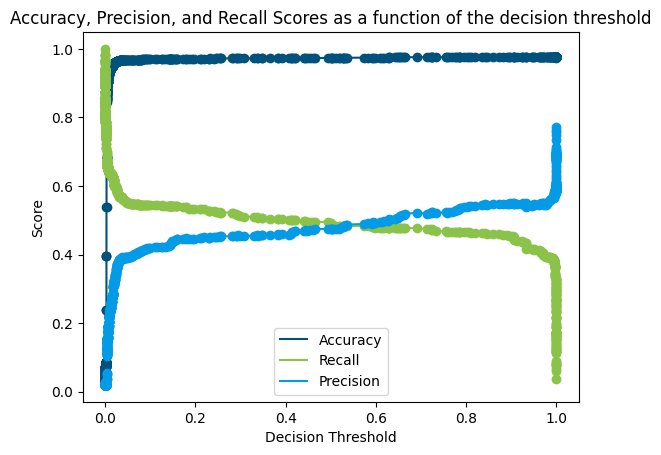

In [ ]:
# AdaBoost final model
model2 = AdaBoostClassifier(random_state=45, base_estimator=DecisionTreeClassifier(max_depth=8),
                            n_estimators=10, learning_rate=0.02)
model2.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model2, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [ ]:
# AdaBoost decision threshold and results
desired_threshold = 0.005

ypred_prob_train = model2.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model2.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.9071195693380848
Train Recall:  0.9818731117824774
Test Accuracy:  0.875710711848988
Test Recall:  0.7045454545454546


In [ ]:
importance = list(model2.feature_importances_)
name = list(model2.feature_names_in_)
df_ada_importances = pd.DataFrame()
df_ada_importances['Predictor'] = name
df_ada_importances['Importance'] = importance
df_ada_importances.sort_values(by='Importance', ascending=False).head(10)

,Predictor,Importance
32,dporpag,0.236788
23,adjoe,0.188406
450,yr_Sr,0.109027
39,ogbpm,0.031881
446,yr_Fr,0.031107
34,bpm,0.022158
37,gbpm,0.020988
25,year,0.018132
22,porpag,0.017317
33,stops,0.012586


### Bagged Decision Trees
*By Isabel Knight*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV 
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

In [ ]:
#getting data and dropping unnecessary columns
data = stats_unique
data = data.set_index('player_name')
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type', 'pid'], axis=1)

#getting dummies of all variables
data_dummified = pd.get_dummies(data)

#splitting data 60/40 and stratifying
y = data_dummified.drafted
X = data_dummified.drop('drafted', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45, stratify = y)

In [ ]:
#DT hyperparameter grid
    #using RandomizedSearchCV at 3 KFolds for computational efficiency since my laptop sucks

n_samples = X_train.shape[0]
n_features = X_train.shape[1]

#param grid
params = {'base_estimator': [DecisionTreeClassifier(random_state = 45)],
          'n_estimators': [250, 400, 800, 1200],
          'max_features': [0.3, 0.5, 0.7, 1],
          'max_samples': [0.5, 1],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

#KFold of 3
cv = KFold(n_splits = 3,shuffle = True, random_state=45)
#randomized grid search
bagging_class_grid = RandomizedSearchCV(estimator = (BaggingClassifier(random_state = 45, n_jobs = -1)),
                                        param_distributions = params,
                                        cv = cv,
                                        n_jobs = -1,
                                        verbose = True,
                                        scoring = ['precision', 'recall'],
                                        refit='recall')


bagging_class_grid.fit(X_train, y_train.values.reshape(-1, 1))


print('Best Parameters : ',bagging_class_grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\blueg\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters :  {'n_estimators': 250, 'max_samples': 0.5, 'max_features': 0.3, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': DecisionTreeClassifier(random_state=45)}


In [ ]:
best_model_1 = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 45),
                                 n_estimators = 250, 
                                 max_features = 0.3, 
                                 max_samples = 0.5,
                                 bootstrap = False, 
                                 bootstrap_features = True, 
                                 random_state = 45, 
                                 n_jobs = -1).fit(X_train, y_train)

In [ ]:
#model feature importances

total = [0] * len(X_train.columns)
# Loop through every tree in bagging classifier
for i, temp_model in enumerate(best_model_1.estimators_): # model is bagging classifier
    feature = best_model_1.estimators_features_[i] # get the predictors the specific tree uses
    for j, predictor in enumerate(feature): # loop the predictors
        total[predictor] += temp_model.feature_importances_[j] # add the specific feature importance to the array
       
np.array(total)/len(best_model_1.estimators_) #convert to numpy array for easy elementwise division


df_dt_importances = pd.DataFrame({'Predictor': best_model_1.feature_names_in_, 'Importance': np.array(total)/len(best_model_1.estimators_)})
df_dt_importances.sort_values(by = 'Importance', ascending = False).head(10)


,Predictor,Importance
32,dporpag,0.065819
37,gbpm,0.056466
22,porpag,0.047709
34,bpm,0.047037
33,stops,0.039990
39,ogbpm,0.028669
23,adjoe,0.024799
0,GP,0.021645
36,dbpm,0.021078
450,yr_Sr,0.020601


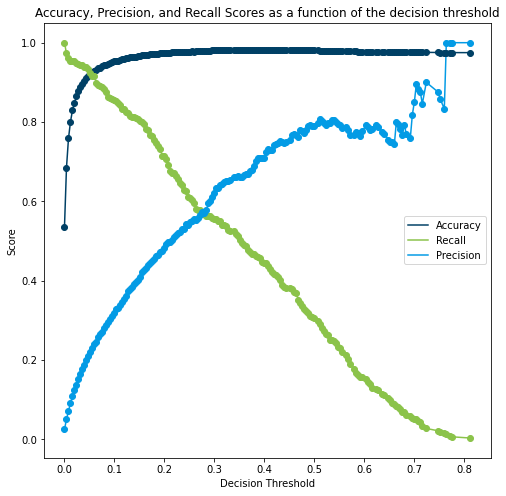

In [ ]:
#finding the optimal threshold
cross_val_ypred = cross_val_predict(best_model_1, X_train, y_train, cv = 3, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys) 

#creating a df of thresholds, recall, precision, and accuracy
df_thr = pd.DataFrame({'thr': thresholds, 'recall': r[:-1], 'acc': accuracys, 'precision': p[:-1]})

#plotting a curve of recall, precision, and accuracy at all thresholds
def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, '#004065', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "#039be5", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='#004065')
    plt.plot(thresholds, recalls[:-1], "o", color = '#8bc34a')
    plt.plot(thresholds, precisions[:-1], "o", color='#039be5')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [ ]:
#what thresholds provide an accuracy and recall above 90%?
df_thr[(df_thr['acc'] > 0.9) & (df_thr['recall'] > 0.9)]

,thr,recall,acc,precision
10,0.040,0.939577,0.903708,0.188029
11,0.044,0.939577,0.910001,0.199231
12,0.048,0.933535,0.916294,0.209634
13,0.052,0.924471,0.920616,0.220939
14,0.056,0.915408,0.925013,0.229198
15,0.060,0.915408,0.928349,0.239715


Train Accuracy: 95.47%
Train Recall: 100.0%
Test Accuracy: 91.56%
Test Recall: 94.09%


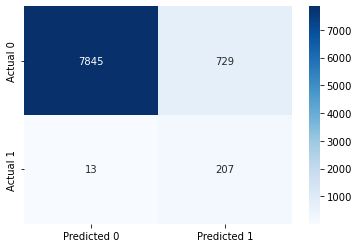

In [ ]:
#choosing 0.048 as I feel it was good balance between accuracy and recall
desired_threshold = 0.048

#getting train accuracy and recall
ypred_prob_train = best_model_1.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

#getting test accuracy and recall
ypred_prob_test = best_model_1.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: " + str(round(accuracy_score(y_train, ypred_train)*100, 2)) + "%")
print("Train Recall: " + str(recall_score(y_train, ypred_train)*100) + "%")
print("Test Accuracy: " + str(round(accuracy_score(y_test, ypred_test)*100, 2)) + "%")
print("Test Recall: " + str(round(recall_score(y_test, ypred_test)*100, 2)) + "%")

#confusion matrix of test data
cm = pd.DataFrame(confusion_matrix(y_test, ypred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### XGBoost
*By Atharva Weling*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBClassifier
import time

In [ ]:
## getting data and dropping unnecessary columns
data = stats_unique
data = data.set_index('player_name')
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type', 'pid'], axis=1)

## getting dummies of all variables
data_dummified = pd.get_dummies(data)

## splitting data 60/40 and stratifying
y = data_dummified.drafted
X = data_dummified.drop('drafted', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45, stratify = y)

In [ ]:
## Finding ideal scale_pos_weight from #Class 0/#Class 1

train = pd.concat([X_train, y_train], axis=1)

class0 = train.loc[train['drafted'] == 0,:]
class1 = train.loc[train['drafted'] == 1,:]
spw = len(class0)/len(class1)
print(spw)

38.84592145015106


In [ ]:
## Randomized search on KFold with 3 splits - not running here for time's sake

param_grid = {'n_estimators':[50,100,500],
              'max_depth': [6,8,10],
              'learning_rate': [0.01,0.05,0.1],
              'gamma': [0.1,0.25,0.5],
              'reg_lambda':[0.001,0.01,0.1],
              'subsample':[0.1,0.3,0.5]}

cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=XGBClassifier(random_state=45, scale_pos_weight=spw), param_distributions=param_grid, 
                                    scoring='recall', verbose=1, n_jobs=-1, cv=cv, n_iter=200)

optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)

In [ ]:
## Best model

xgbmodel = XGBClassifier(random_state=45, gamma=0.5, learning_rate = 0.01, max_depth=6, n_estimators=25, 
                      reg_lambda=0.01, subsample=0.75, scale_pos_weight=spw).fit(X_train, y_train)

In [ ]:
## Cross val pred on XGBoost model

cross_val_ypred = cross_val_predict(xgbmodel, X_train, y_train, cv = 5, method = 'predict_proba')

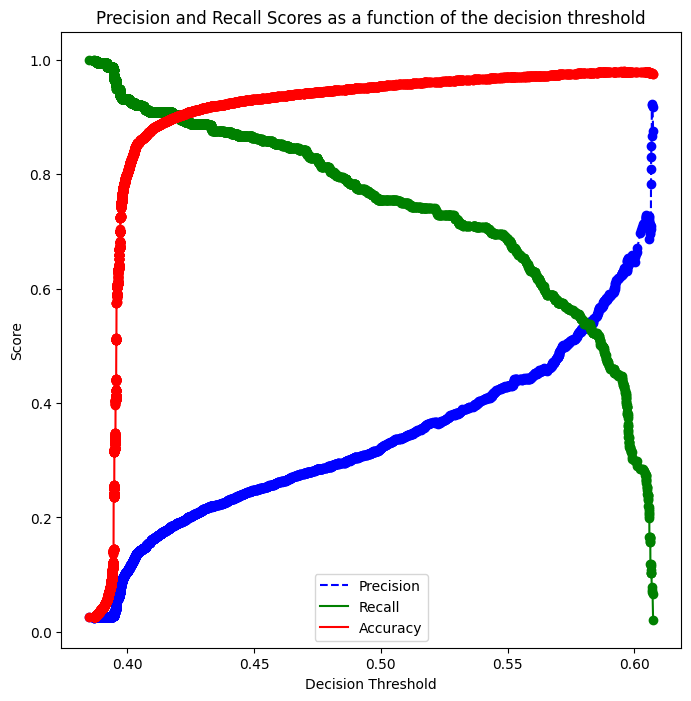

In [ ]:
## Plot accuracy, recall, precision

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# Train data - finding ideal threshold for accuracy and recall from plot

# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.44

y_pred_prob = xgbmodel.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy and recall
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  
print("Recall: ", recall_score(y_train, y_pred))

Accuracy:  93.13822124497688
Recall:  0.9788519637462235


In [ ]:
# Test data - finding ideal threshold for accuracy and recall from plot

# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.44

y_pred_prob = xgbmodel.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy and recall
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  92.48351148510348
Recall:  0.9090909090909091


In [ ]:
# Feature importances

importance = list(xgbmodel.feature_importances_)
predictor = list(xgbmodel.feature_names_in_)
df_xgb_importances = pd.DataFrame()
df_xgb_importances['Predictor'] = predictor
df_xgb_importances['Importance'] = importance
df_xgb_importances.sort_values(by='Importance', ascending=False).head(10)

,Predictor,Importance
32,dporpag,0.303467
37,gbpm,0.068579
34,bpm,0.022012
446,yr_Fr,0.019540
29,dunksmade,0.015797
439,conf_SEC,0.014534
450,yr_Sr,0.014382
35,obpm,0.013951
22,porpag,0.013934
39,ogbpm,0.013644


## Model Ensemble
*All done by Isabel Knight*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


##### Creating a dataframe of all the feature importances as determined by the individual models

In [ ]:
xgb = df_xgb_importances.rename(columns = {"Importance": "Importance by XGB Model"})
bagged_dt = df_dt_importances.rename(columns = {"Importance": "Importance by Bagged DT Model"})
ada = df_ada_importances.rename(columns = {"Importance": "Importance by AdaBoost Model"})
rf = df_rf_importances.rename(columns = {"Importance": "Importance by RF Model"})

df_importances_2 = xgb.merge(bagged_dt, on = 'Predictor')
df_importances_3 = df_importances_2.merge(ada, on = 'Predictor')

#final df of all 4 model feature importances
df_importances = df_importances_3.merge(rf, on = 'Predictor')


### Soft voting ensemble
*By Isabel Knight*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
import itertools as it
import time as time
import xgboost as xgb

#splitting data 60/40 and stratifying (this is loaded from DT code cells)
y = data_dummified.drafted
X = data_dummified.drop('drafted', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45, stratify = y)

#for xgboost
train = pd.concat([X_train, y_train], axis=1)
class0 = train.loc[train['drafted'] == 0,:]
class1 = train.loc[train['drafted'] == 1,:]
spw = len(class0)/len(class1)

In [ ]:
### All of our models

## best DT model
model_dt = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 45),
                                 n_estimators = 250, 
                                 max_features = 0.3, 
                                 max_samples = 0.5,
                                 bootstrap = False, 
                                 bootstrap_features = True, 
                                 random_state = 45, 
                                 n_jobs = -1).fit(X_train, y_train)
## best AdaBoost Model
model_ada = AdaBoostClassifier(random_state = 45, 
                               base_estimator = DecisionTreeClassifier(max_depth = 8),
                               n_estimators = 10, 
                               learning_rate = 0.02).fit(X_train, y_train)

## best RF model
model_rf = RandomForestClassifier(random_state = 45, 
                                  bootstrap = False,
                                  n_estimators = 500,
                                  max_leaf_nodes = 500,
                                  max_depth = 20,
                                  n_jobs=-1).fit(X_train, y_train)

## best XGBoost model
model_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                              random_state = 45, 
                              gamma = 0.5, 
                              learning_rate = 0.01,
                              max_depth = 6, 
                              n_estimators = 25,
                              reg_lambda = 0.01, 
                              subsample = 0.75,
                              scale_pos_weight = spw).fit(X_train, y_train)

In [ ]:
##getting test classification accuracies of all models
test_accuracy_ada = model_ada.score(X_test, y_test)
test_accuracy_rf = model_rf.score(X_test, y_test) 
test_accuracy_dt = model_dt.score(X_test, y_test)
test_accuracy_xgb = model_xgb.score(X_test, y_test)


print("Adaboost accuracy = " + str((test_accuracy_ada)*100) + "%")
print("Random forest accuracy = " + str((test_accuracy_rf)*100) + "%")
print("Decision Tree accuracy = " + str((test_accuracy_dt)*100) + "%")
print("XGBoost accuracy = " + str((test_accuracy_xgb)*100) + "%")

Adaboost accuracy = 97.35046622697293%
Random forest accuracy = 98.1009779395042%
Decision Tree accuracy = 98.06686377075279%
XGBoost accuracy = 95.6788719581533%


In [ ]:
sv_ensemble_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('dt',model_dt),('xgb',model_xgb)],
                                 voting='soft')
sv_ensemble_model.fit(X_train,y_train)
print("Soft voting ensemble model accuracy = " + str(sv_ensemble_model.score(X_test, y_test)*100))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Soft voting ensemble model accuracy = 98.1009779395042


In [ ]:
#finding feature importance of soft voting model
weights = [1 / len(sv_ensemble_model.estimators_)] * len(sv_ensemble_model.estimators_)

# Print the weights of each model
for name, weight in zip(sv_ensemble_model.named_estimators_.keys(), weights):
    print(f"Model: {name}, Weight: {weight}")



Model: ada, Weight: 0.25
Model: rf, Weight: 0.25
Model: dt, Weight: 0.25
Model: xgb, Weight: 0.25


In [ ]:
df_importances["Weighted Importance for SV"] = 0.25*df_importances["Importance by XGB Model"] + 0.25*df_importances["Importance by AdaBoost Model"] + 0.25*df_importances["Importance by RF Model"] + 0.25*df_importances["Importance by Bagged DT Model"]

df_importances[["Predictor", "Weighted Importance for SV"]].sort_values(by = "Weighted Importance for SV", ascending=False).head(10)   

,Predictor,Weighted Importance for SV
32,dporpag,0.163970
23,adjoe,0.063228
37,gbpm,0.047474
450,yr_Sr,0.041974
34,bpm,0.031549
22,porpag,0.028863
39,ogbpm,0.025716
33,stops,0.024511
446,yr_Fr,0.021325
29,dunksmade,0.016655


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

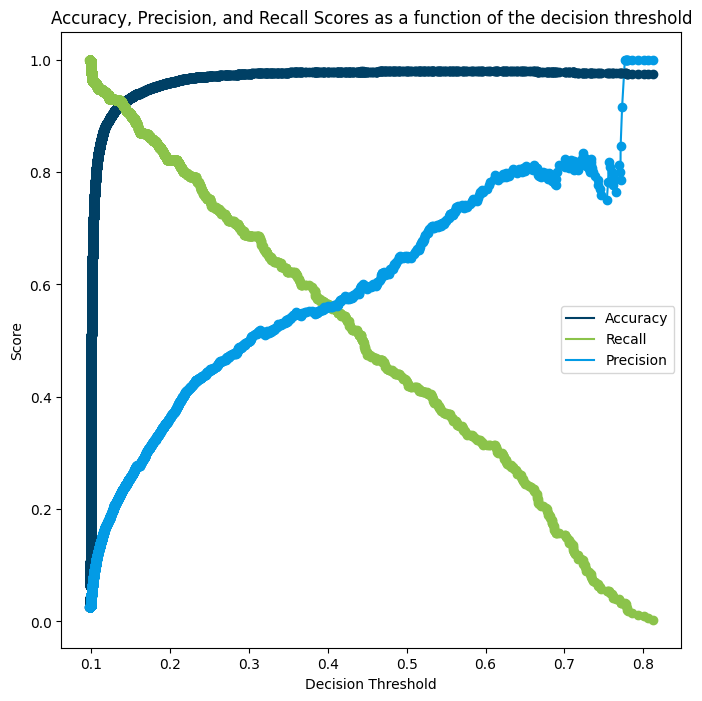

In [ ]:
#finding the optimal threshold
cross_val_ypred = cross_val_predict(sv_ensemble_model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys) 

#creating a df of thresholds, recall, precision, and accuracy
df_thr = pd.DataFrame({'thr': thresholds, 'recall': r[:-1], 'acc': accuracys, 'precision': p[:-1]})

#plotting a curve of recall, precision, and accuracy at all thresholds
def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, '#004065', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "#039be5", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='#004065')
    plt.plot(thresholds, recalls[:-1], "o", color = '#8bc34a')
    plt.plot(thresholds, precisions[:-1], "o", color='#039be5')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [ ]:
#what threshold provides a training recall and accuracy abobe 91.6%?
df_thr[(df_thr['recall'] > 0.916) & (df_thr['acc'] > 0.916)]

,thr,recall,acc,precision
10805,0.135144,0.927492,0.916066,0.220705
10806,0.135170,0.927492,0.916142,0.220863
10807,0.135224,0.927492,0.916218,0.221022
10808,0.135268,0.927492,0.916294,0.221182
10809,0.135361,0.927492,0.916370,0.221341
...,...,...,...,...
10925,0.142060,0.918429,0.924710,0.239182
10926,0.142135,0.918429,0.924786,0.239370
10927,0.142161,0.918429,0.924862,0.239559
10928,0.142170,0.918429,0.924937,0.239748


Train Accuracy: 95.85%
Train Recall: 100.0%
Test Accuracy: 91.94%
Test Recall: 93.18%


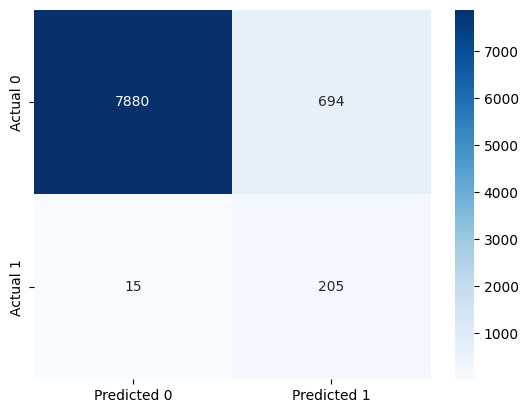

In [ ]:
#choosing 0.138327 
desired_threshold = 0.138327

#getting train accuracy and recall
ypred_prob_train = sv_ensemble_model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

#getting test accuracy and recall
ypred_prob_test = sv_ensemble_model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: " + str(round(accuracy_score(y_train, ypred_train)*100, 2)) + "%")
print("Train Recall: " + str(recall_score(y_train, ypred_train)*100) + "%")
print("Test Accuracy: " + str(round(accuracy_score(y_test, ypred_test)*100, 2)) + "%")
print("Test Recall: " + str(round(recall_score(y_test, ypred_test)*100, 2)) + "%")

#confusion matrix of test data
cm = pd.DataFrame(confusion_matrix(y_test, ypred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### Stacking ensemble(s)

#### Using Logistic Regression as meta-model

In [ ]:

stacking_ensemble_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('dt',model_dt),('xgb',model_xgb)],
                                   final_estimator=LogisticRegression(random_state=45,max_iter=10000),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=45))
stacking_ensemble_model.fit(X_train,y_train)
print("Stacking Classifier Ensemble accuracy =",stacking_ensemble_model.score(X_test, y_test)*100)

Stacking Classifier Ensemble accuracy = 98.16920627700705


In [ ]:

# Get the feature importances of the final estimator (LogisticRegression)
final_estimator_coef = stacking_ensemble_model.final_estimator_.coef_[0]

# Normalize the coefficients to obtain the weights
weights = final_estimator_coef / np.sum(final_estimator_coef)

# Print the weights of each model
for name, weight in zip(stacking_ensemble_model.named_estimators_.keys(), weights):
    print(f"Model: {name}, Weight: {weight}")


Model: ada, Weight: 0.09025205516485636
Model: rf, Weight: 0.2981302449575167
Model: dt, Weight: 0.27420636418946864
Model: xgb, Weight: 0.33741133568815823


In [ ]:
df_importances["Weighted Importance for Stacking"] = 0.3422681507325754*df_importances["Importance by XGB Model"] + 0.08774746732991848*df_importances["Importance by AdaBoost Model"] + 0.2965995957650995*df_importances["Importance by RF Model"] + 0.2733847861724067*df_importances["Importance by Bagged DT Model"]

df_importances[["Predictor", "Weighted Importance for Stacking"]].sort_values(by = "Weighted Importance for Stacking", ascending=False).head(10)   

,Predictor,Weighted Importance for Stacking
32,dporpag,0.157412
37,gbpm,0.053761
23,adjoe,0.035681
34,bpm,0.032715
22,porpag,0.030155
450,yr_Sr,0.027206
33,stops,0.025910
39,ogbpm,0.023809
446,yr_Fr,0.019314
29,dunksmade,0.017529


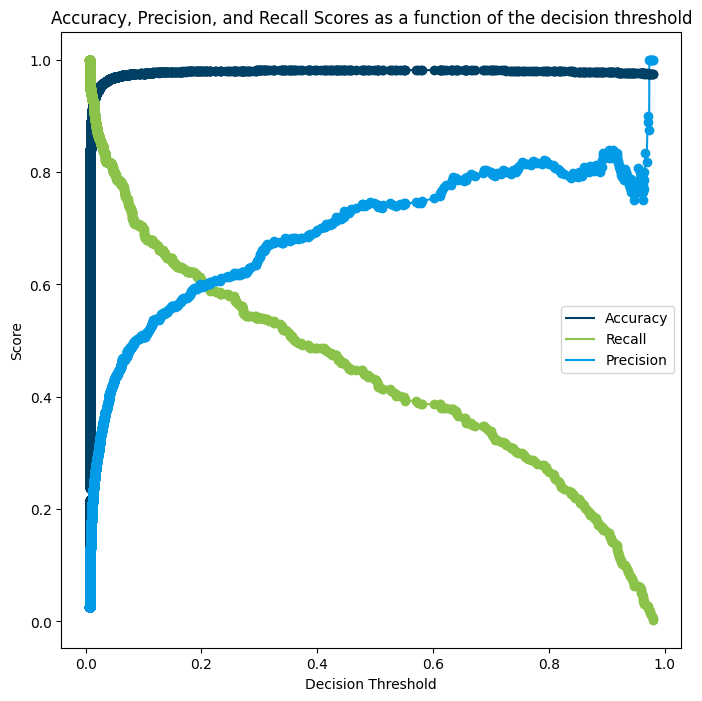

In [ ]:
#finding the optimal threshold
cross_val_ypred = cross_val_predict(stacking_ensemble_model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys) 

#creating a df of thresholds, recall, precision, and accuracy
df_thr = pd.DataFrame({'thr': thresholds, 'recall': r[:-1], 'acc': accuracys, 'precision': p[:-1]})

#plotting a curve of recall, precision, and accuracy at all thresholds
def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, '#004065', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "#039be5", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='#004065')
    plt.plot(thresholds, recalls[:-1], "o", color = '#8bc34a')
    plt.plot(thresholds, precisions[:-1], "o", color='#039be5')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [ ]:
df_thr[(df_thr['recall'] > 0.916) & (df_thr['acc'] > 0.916)]

,thr,recall,acc,precision
10816,0.012387,0.927492,0.916066,0.220705
10817,0.012410,0.927492,0.916142,0.220863
10818,0.012426,0.927492,0.916218,0.221022
10819,0.012431,0.927492,0.916294,0.221182
10820,0.012451,0.927492,0.916370,0.221341
...,...,...,...,...
10949,0.013954,0.921450,0.925696,0.242448
10950,0.013955,0.918429,0.925771,0.241846
10951,0.013961,0.918429,0.925847,0.242038
10952,0.013994,0.918429,0.925923,0.242231


Train Accuracy: 95.91%
Train Recall: 100.0%
Test Accuracy: 92.23%
Test Recall: 92.27%


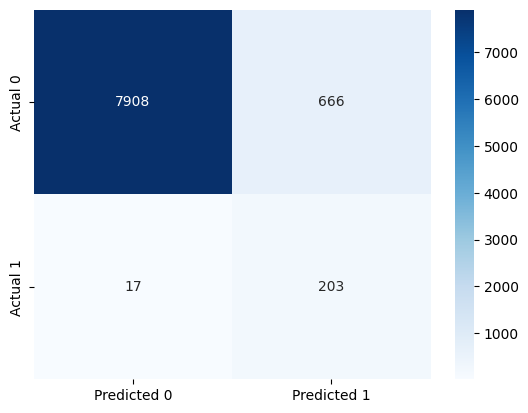

In [ ]:
#choosing 0.012832 
desired_threshold = 0.012832

#getting train accuracy and recall
ypred_prob_train = stacking_ensemble_model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

#getting test accuracy and recall
ypred_prob_test = stacking_ensemble_model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: " + str(round(accuracy_score(y_train, ypred_train)*100, 2)) + "%")
print("Train Recall: " + str(recall_score(y_train, ypred_train)*100) + "%")
print("Test Accuracy: " + str(round(accuracy_score(y_test, ypred_test)*100, 2)) + "%")
print("Test Recall: " + str(round(recall_score(y_test, ypred_test)*100, 2)) + "%")

#confusion matrix of test data
cm = pd.DataFrame(confusion_matrix(y_test, ypred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.